In [10]:
import pykitti
import numpy as np

In [5]:
basedir = 'C:/Users/nilay/Downloads/raw'
#basedir = 'C:/Users/nilay/Downloads'
date = '2011_09_26'
drive = '0001'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
data = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))

In [32]:
dataset = data

In [8]:
# dataset.calib:         Calibration data are accessible as a named tuple
# dataset.timestamps:    Timestamps are parsed into a list of datetime objects
# dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
# dataset.camN:          Returns a generator that loads individual images from camera N
# dataset.get_camN(idx): Returns the image from camera N at idx  
# dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
# dataset.get_gray(idx): Returns the monochrome stereo pair at idx  
# dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
# dataset.get_rgb(idx):  Returns the RGB stereo pair at idx  
# dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
# dataset.get_velo(idx): Returns the velodyne scan at idx  

In [11]:
point_velo = np.array([0,0,0,1])
point_cam0 = data.calib.T_cam0_velo.dot(point_velo)

In [13]:
point_imu = np.array([0,0,0,1])
point_w = [o.T_w_imu.dot(point_imu) for o in data.oxts]

In [14]:
for cam0_image in data.cam0:
    # do something
    pass

cam2_image, cam3_image = data.get_rgb(3)

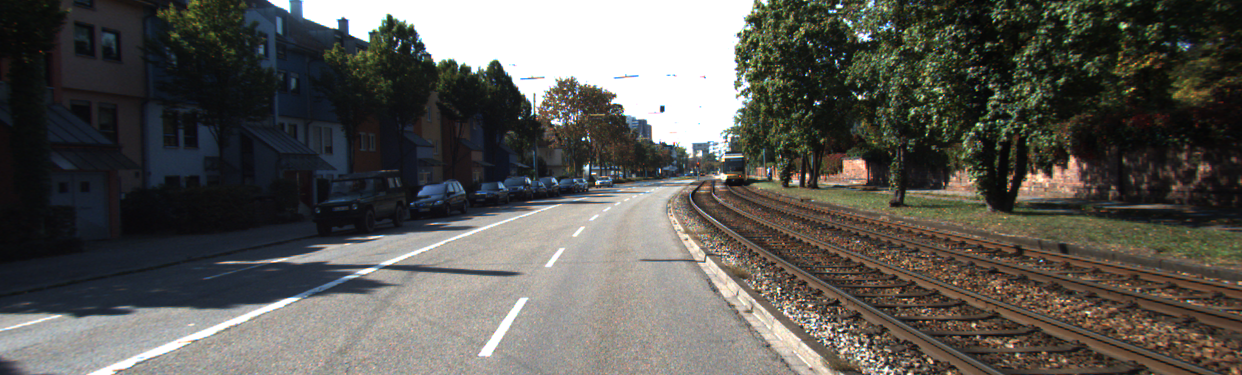

In [27]:
cam2_image

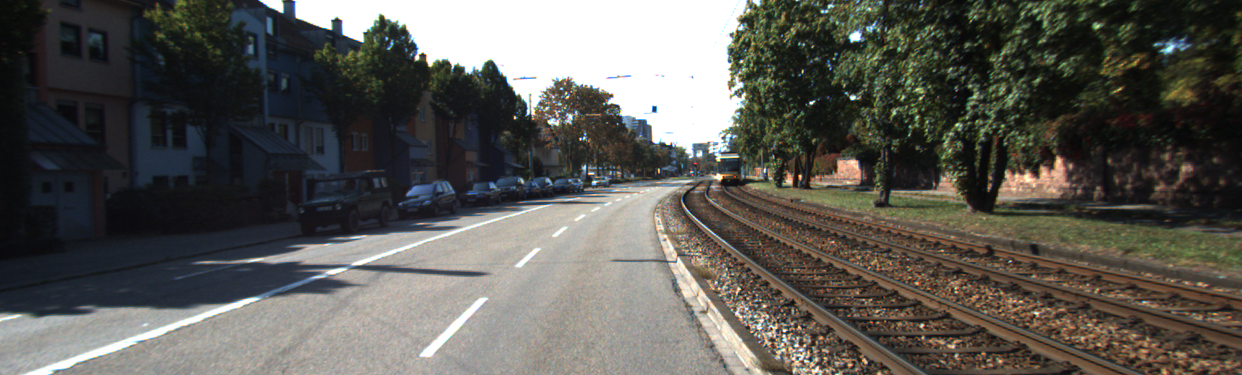

In [28]:
cam3_image

In [26]:
cam2_image, cam3_image = data.get_rgb(0)

In [38]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [33]:
# Grab some data
second_pose = dataset.oxts[1].T_w_imu
first_gray = next(iter(dataset.gray))
first_cam1 = next(iter(dataset.cam1))
first_rgb = dataset.get_rgb(0)
first_cam2 = dataset.get_cam2(0)
third_velo = dataset.get_velo(2)


Drive: 2011_09_26_drive_0001_sync

Frame range: range(0, 50, 5)

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600500771

RGB stereo pair baseline [m]: 0.5327254400790535

First timestamp: 2011-09-26 13:02:25.964389

Second IMU pose:
[[-0.8678  0.4963 -0.0243 -5.8173]
 [-0.4968 -0.8675  0.0254 -3.4647]
 [-0.0084  0.0341  0.9994  0.0236]
 [ 0.      0.      0.      1.    ]]


Text(0.5, 1.0, 'Right RGB Image (cam3)')

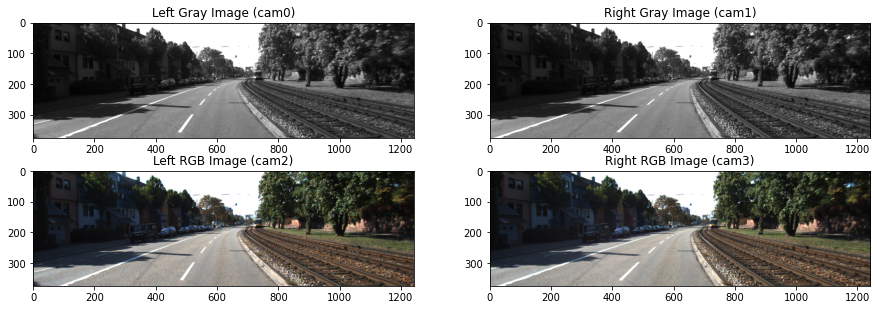

In [39]:
# Display some of the data
np.set_printoptions(precision=4, suppress=True)
print('\nDrive: ' + str(dataset.drive))
print('\nFrame range: ' + str(dataset.frames))

print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

print('\nFirst timestamp: ' + str(dataset.timestamps[0]))
print('\nSecond IMU pose:\n' + str(second_pose))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_gray[0], cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(first_cam1, cmap='gray')
ax[0, 1].set_title('Right Gray Image (cam1)')

ax[1, 0].imshow(first_cam2)
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(first_rgb[1])
ax[1, 1].set_title('Right RGB Image (cam3)')

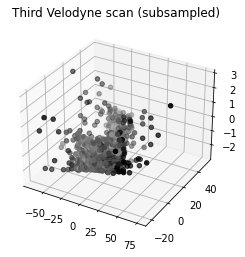

In [40]:
f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()

In [ ]:
#!/usr/bin/env python
"""
parse XML files containing tracklet info for kitti data base (raw data section)
(http://cvlibs.net/datasets/kitti/raw_data.php)

No guarantees that this code is correct, usage is at your own risk!

created by Christian Herdtweck, Max Planck Institute for Biological Cybernetics
  (christian.herdtweck@tuebingen.mpg.de)

requires numpy!

example usage:
  import parseTrackletXML as xmlParser
  kittiDir = '/path/to/kitti/data'
  drive = '2011_09_26_drive_0001'
  xmlParser.example(kittiDir, drive)
or simply on command line:
  python parseTrackletXML.py
"""

# Version History:
# 4/7/12 Christian Herdtweck: seems to work with a few random test xml tracklet files; 
#   converts file contents to ElementTree and then to list of Tracklet objects; 
#   Tracklet objects have str and iter functions
# 5/7/12 ch: added constants for state, occlusion, truncation and added consistency checks
# 30/1/14 ch: create example function from example code

from sys import argv as cmdLineArgs
from xml.etree.ElementTree import ElementTree
import numpy as np
import itertools
from warnings import warn

STATE_UNSET = 0
STATE_INTERP = 1
STATE_LABELED = 2
stateFromText = {'0':STATE_UNSET, '1':STATE_INTERP, '2':STATE_LABELED}

OCC_UNSET = 255  # -1 as uint8
OCC_VISIBLE = 0
OCC_PARTLY = 1
OCC_FULLY = 2
occFromText = {'-1':OCC_UNSET, '0':OCC_VISIBLE, '1':OCC_PARTLY, '2':OCC_FULLY}

TRUNC_UNSET = 255  # -1 as uint8, but in xml files the value '99' is used!
TRUNC_IN_IMAGE = 0
TRUNC_TRUNCATED = 1
TRUNC_OUT_IMAGE = 2
TRUNC_BEHIND_IMAGE = 3
truncFromText = {'99':TRUNC_UNSET, '0':TRUNC_IN_IMAGE, '1':TRUNC_TRUNCATED, \
                  '2':TRUNC_OUT_IMAGE, '3': TRUNC_BEHIND_IMAGE}


class Tracklet(object):
  r""" representation an annotated object track 
  
  Tracklets are created in function parseXML and can most conveniently used as follows:

  for trackletObj in parseXML(trackletFile):
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
      ... your code here ...
    #end: for all frames
  #end: for all tracklets

  absoluteFrameNumber is in range [firstFrame, firstFrame+nFrames[
  amtOcclusion and amtBorders could be None

  You can of course also directly access the fields objType (string), size (len-3 ndarray), firstFrame/nFrames (int), 
    trans/rots (nFrames x 3 float ndarrays), states/truncs (len-nFrames uint8 ndarrays), occs (nFrames x 2 uint8 ndarray),
    and for some tracklets amtOccs (nFrames x 2 float ndarray) and amtBorders (nFrames x 3 float ndarray). The last two
    can be None if the xml file did not include these fields in poses
  """

  objectType = None
  size = None  # len-3 float array: (height, width, length)
  firstFrame = None
  trans = None   # n x 3 float array (x,y,z)
  rots = None    # n x 3 float array (x,y,z)
  states = None  # len-n uint8 array of states
  occs = None    # n x 2 uint8 array  (occlusion, occlusion_kf)
  truncs = None  # len-n uint8 array of truncation
  amtOccs = None    # None or (n x 2) float array  (amt_occlusion, amt_occlusion_kf)
  amtBorders = None    # None (n x 3) float array  (amt_border_l / _r / _kf)
  nFrames = None

  def __init__(self):
    r""" create Tracklet with no info set """
    self.size = np.nan*np.ones(3, dtype=float)

  def __str__(self):
    r""" return human-readable string representation of tracklet object

    called implicitly in 
    print trackletObj
    or in 
    text = str(trackletObj)
    """
    return '[Tracklet over {0} frames for {1}]'.format(self.nFrames, self.objectType)

  def __iter__(self):
    r""" returns an iterator that yields tuple of all the available data for each frame 
    
    called whenever code iterates over a tracklet object, e.g. in 
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
      ...do something ...
    or
    trackDataIter = iter(trackletObj)
    """
    if self.amtOccs is None:
      return itertools.izip(self.trans, self.rots, self.states, self.occs, self.truncs, \
          itertools.repeat(None), itertools.repeat(None), xrange(self.firstFrame, self.firstFrame+self.nFrames))
    else:
      return itertools.izip(self.trans, self.rots, self.states, self.occs, self.truncs, \
          self.amtOccs, self.amtBorders, xrange(self.firstFrame, self.firstFrame+self.nFrames))
#end: class Tracklet


def parseXML(trackletFile):
  r""" parse tracklet xml file and convert results to list of Tracklet objects
  
  :param trackletFile: name of a tracklet xml file
  :returns: list of Tracklet objects read from xml file
  """

  # convert tracklet XML data to a tree structure
  eTree = ElementTree()
  print 'parsing tracklet file', trackletFile
  with open(trackletFile) as f:
    eTree.parse(f)

  # now convert output to list of Tracklet objects
  trackletsElem = eTree.find('tracklets')
  tracklets = []
  trackletIdx = 0
  nTracklets = None
  for trackletElem in trackletsElem:
    #print 'track:', trackletElem.tag
    if trackletElem.tag == 'count':
      nTracklets = int(trackletElem.text)
      print 'file contains', nTracklets, 'tracklets'
    elif trackletElem.tag == 'item_version':
      pass
    elif trackletElem.tag == 'item':
      #print 'tracklet {0} of {1}'.format(trackletIdx, nTracklets)
      # a tracklet
      newTrack = Tracklet()
      isFinished = False
      hasAmt = False
      frameIdx = None
      for info in trackletElem:
        #print 'trackInfo:', info.tag
        if isFinished:
          raise ValueError('more info on element after finished!')
        if info.tag == 'objectType':
          newTrack.objectType = info.text
        elif info.tag == 'h':
          newTrack.size[0] = float(info.text)
        elif info.tag == 'w':
          newTrack.size[1] = float(info.text)
        elif info.tag == 'l':
          newTrack.size[2] = float(info.text)
        elif info.tag == 'first_frame':
          newTrack.firstFrame = int(info.text)
        elif info.tag == 'poses':
          # this info is the possibly long list of poses
          for pose in info:
            #print 'trackInfoPose:', pose.tag
            if pose.tag == 'count':   # this should come before the others
              if newTrack.nFrames is not None:
                raise ValueError('there are several pose lists for a single track!')
              elif frameIdx is not None:
                raise ValueError('?!')
              newTrack.nFrames = int(pose.text)
              newTrack.trans  = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
              newTrack.rots   = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
              newTrack.states = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
              newTrack.occs   = np.nan * np.ones((newTrack.nFrames, 2), dtype='uint8')
              newTrack.truncs = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
              newTrack.amtOccs = np.nan * np.ones((newTrack.nFrames, 2), dtype=float)
              newTrack.amtBorders = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
              frameIdx = 0
            elif pose.tag == 'item_version':
              pass
            elif pose.tag == 'item':
              # pose in one frame
              if frameIdx is None:
                raise ValueError('pose item came before number of poses!')
              for poseInfo in pose:
                #print 'trackInfoPoseInfo:', poseInfo.tag
                if poseInfo.tag == 'tx':
                  newTrack.trans[frameIdx, 0] = float(poseInfo.text)
                elif poseInfo.tag == 'ty':
                  newTrack.trans[frameIdx, 1] = float(poseInfo.text)
                elif poseInfo.tag == 'tz':
                  newTrack.trans[frameIdx, 2] = float(poseInfo.text)
                elif poseInfo.tag == 'rx':
                  newTrack.rots[frameIdx, 0] = float(poseInfo.text)
                elif poseInfo.tag == 'ry':
                  newTrack.rots[frameIdx, 1] = float(poseInfo.text)
                elif poseInfo.tag == 'rz':
                  newTrack.rots[frameIdx, 2] = float(poseInfo.text)
                elif poseInfo.tag == 'state':
                  newTrack.states[frameIdx] = stateFromText[poseInfo.text]
                elif poseInfo.tag == 'occlusion':
                  newTrack.occs[frameIdx, 0] = occFromText[poseInfo.text]
                elif poseInfo.tag == 'occlusion_kf':
                  newTrack.occs[frameIdx, 1] = occFromText[poseInfo.text]
                elif poseInfo.tag == 'truncation':
                  newTrack.truncs[frameIdx] = truncFromText[poseInfo.text]
                elif poseInfo.tag == 'amt_occlusion':
                  newTrack.amtOccs[frameIdx,0] = float(poseInfo.text)
                  hasAmt = True
                elif poseInfo.tag == 'amt_occlusion_kf':
                  newTrack.amtOccs[frameIdx,1] = float(poseInfo.text)
                  hasAmt = True
                elif poseInfo.tag == 'amt_border_l':
                  newTrack.amtBorders[frameIdx,0] = float(poseInfo.text)
                  hasAmt = True
                elif poseInfo.tag == 'amt_border_r':
                  newTrack.amtBorders[frameIdx,1] = float(poseInfo.text)
                  hasAmt = True
                elif poseInfo.tag == 'amt_border_kf':
                  newTrack.amtBorders[frameIdx,2] = float(poseInfo.text)
                  hasAmt = True
                else:
                  raise ValueError('unexpected tag in poses item: {0}!'.format(poseInfo.tag))
              frameIdx += 1
            else:
              raise ValueError('unexpected pose info: {0}!'.format(pose.tag))
        elif info.tag == 'finished':
          isFinished = True
        else:
          raise ValueError('unexpected tag in tracklets: {0}!'.format(info.tag))
      #end: for all fields in current tracklet

      # some final consistency checks on new tracklet
      if not isFinished:
        warn('tracklet {0} was not finished!'.format(trackletIdx))
      if newTrack.nFrames is None:
        warn('tracklet {0} contains no information!'.format(trackletIdx))
      elif frameIdx != newTrack.nFrames:
        warn('tracklet {0} is supposed to have {1} frames, but perser found {1}!'.format(\
            trackletIdx, newTrack.nFrames, frameIdx))
      if np.abs(newTrack.rots[:,:2]).sum() > 1e-16:
        warn('track contains rotation other than yaw!')

      # if amtOccs / amtBorders are not set, set them to None
      if not hasAmt:
        newTrack.amtOccs = None
        newTrack.amtBorders = None

      # add new tracklet to list
      tracklets.append(newTrack)
      trackletIdx += 1

    else:
      raise ValueError('unexpected tracklet info')
  #end: for tracklet list items

  print 'loaded', trackletIdx, 'tracklets'

  # final consistency check
  if trackletIdx != nTracklets:
    warn('according to xml information the file has {0} tracklets, but parser found {1}!'.format(nTracklets, trackletIdx))

  return tracklets
#end: function parseXML


def example(kittiDir=None, drive=None):

  from os.path import join, expanduser
  import readline    # makes raw_input behave more fancy
  # from xmlParser import parseXML, TRUNC_IN_IMAGE, TRUNC_TRUNCATED

  DEFAULT_DRIVE = '2011_09_26_drive_0001'
  twoPi = 2.*np.pi

  # get dir names
  if kittiDir is None:
    kittiDir = expanduser(raw_input('please enter kitti base dir (e.g. ~/path/to/kitti): ').strip())
  if drive is None:
    drive    = raw_input('please enter drive name (default {0}): '.format(DEFAULT_DRIVE)).strip()
    if len(drive) == 0:
      drive = DEFAULT_DRIVE

  # read tracklets from file
  myTrackletFile = join(kittiDir, drive, 'tracklet_labels.xml')
  tracklets = parseXML(myTrackletFile)

  # loop over tracklets
  for iTracklet, tracklet in enumerate(tracklets):
    print 'tracklet {0: 3d}: {1}'.format(iTracklet, tracklet)

    # this part is inspired by kitti object development kit matlab code: computeBox3D
    h,w,l = tracklet.size
    trackletBox = np.array([ # in velodyne coordinates around zero point and without orientation yet\
        [-l/2, -l/2,  l/2, l/2, -l/2, -l/2,  l/2, l/2], \
        [ w/2, -w/2, -w/2, w/2,  w/2, -w/2, -w/2, w/2], \
        [ 0.0,  0.0,  0.0, 0.0,    h,     h,   h,   h]])

    # loop over all data in tracklet
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber \
        in tracklet:

      # determine if object is in the image; otherwise continue
      if truncation not in (TRUNC_IN_IMAGE, TRUNC_TRUNCATED):
        continue

      # re-create 3D bounding box in velodyne coordinate system
      yaw = rotation[2]   # other rotations are 0 in all xml files I checked
      assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
      rotMat = np.array([\
          [np.cos(yaw), -np.sin(yaw), 0.0], \
          [np.sin(yaw),  np.cos(yaw), 0.0], \
          [        0.0,          0.0, 1.0]])
      cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8,1)).T

      # calc yaw as seen from the camera (i.e. 0 degree = facing away from cam), as opposed to 
      #   car-centered yaw (i.e. 0 degree = same orientation as car).
      #   makes quite a difference for objects in periphery!
      # Result is in [0, 2pi]
      x, y, z = translation
      yawVisual = ( yaw - np.arctan2(y, x) ) % twoPi
      
    #end: for all frames in track
  #end: for all tracks
#end: function example

# when somebody runs this file as a script: 
#   run example if no arg or only 'example' was given as arg
#   otherwise run parseXML
if __name__ == "__main__":
  # cmdLineArgs[0] is 'parseTrackletXML.py'
  if len(cmdLineArgs) < 2:
    example()
  elif (len(cmdLineArgs) == 2) and (cmdLineArgs[1] == 'example'):
    example()
  else:
    parseXML(*cmdLineArgs[1:])

# (created using vim - the world's best text editor)
